In [2]:
!mkdir -p data
!gsutil -m cp -r gs://novoic-ml-challenge-text-data/* ./data

Copying gs://novoic-ml-challenge-text-data/LICENSE...
Copying gs://novoic-ml-challenge-text-data/README.md...
Copying gs://novoic-ml-challenge-text-data/data.txt...
/ [3/3 files][468.7 KiB/468.7 KiB] 100% Done                                    
Operation completed over 3 objects/468.7 KiB.                                    


In [0]:
with open('data/data.txt', 'r') as f:
    msgs = f.read().splitlines()

In [4]:
print(msgs[10])
print(msgs[11])

ham	I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today.
spam	SIX chances to win CASH! From 100 to 20,000 pounds txt> CSH11 and send to 87575. Cost 150p/day, 6days, 16+ TsandCs apply Reply HL 4 info


In [5]:
import tensorflow as tf
tf.__version__

'1.15.0'

## **Table of Contents**
### 1. [Preprocessing and Data Exploration](#preprocess)
### 2. [Bag of words model](#bow)
### 3. [TF-IDF](#tfidf)
### 4. [Clustering](#cluster)
### 5. [Supervised Machine Learning](#ml)
### 6. [Parameter Optimisation - Original Data](#gds)
### 7. [Parameter Optimisation - Oversampled Data](#gdso)
### 8. [Critical Analysis](#ca)
### 9. [Referenes](#ref)

# Preprocessing and Data Exploration
<a id="preprocess"></a>

In [0]:
#import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

*Since the class as well as text is in a single line for each message, let's split it so we can create two columns with the split data*

In [0]:
#splitting the messages into category and SMS
msgs_split = [i.split('\t', 1) for i in msgs]

In [0]:
#create a dataframe of the split
msgs_df = pd.DataFrame(msgs_split)

In [9]:
#check the dataframe with some examples
msgs_df.head()

,0,1
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [0]:
#add column headers to the dataframe
msgs_df.columns = ["Class", "SMS"]

In [11]:
#check the dataframe
msgs_df.head()

,Class,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [12]:
#interchanging the columns for ease (doesn't have to be done it's only a personal choice)
column_titles = ["SMS", "Class"]
msgs_df = msgs_df.reindex(columns = column_titles)
msgs_df.head()

,SMS,Class
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham


*Now the data is ready to be investigated. On to some data exploration:*

In [14]:
#Check the contents of the dataframe
msgs_df.describe()

,SMS,Class
count,5574,5574
unique,5171,2
top,"Sorry, I'll call later",ham
freq,30,4827


Text(0.5, 1.0, 'Number of ham and spam messages')

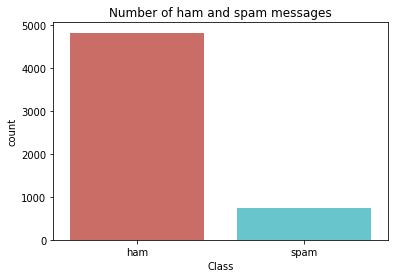

In [15]:
#lets check how many messages each ham and spam classes have
sns.countplot(x = msgs_df['Class'], data = msgs_df, palette ='hls')
plt.title('Number of ham and spam messages')

*This is an imbalanced dataset with the majority class being ham and minority class is spam. This could lead to potential problems causing bias in the performance if machine learning is applied for classification.*

*It would be interesting to see if there are words standing out in each class. Let's try to generate a word cloud for each class*

In [16]:
#import necessary packages
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
import re
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfTransformer
import string

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


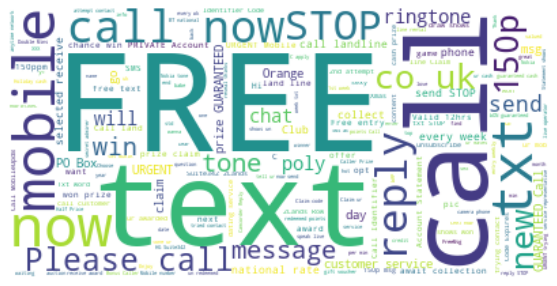

In [17]:
# Create stopword list:
stopwords = set(STOPWORDS)
spam_words = ' '.join(msgs_df[msgs_df['Class'] == 'spam']['SMS'])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(spam_words)

# Display the generated image:
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

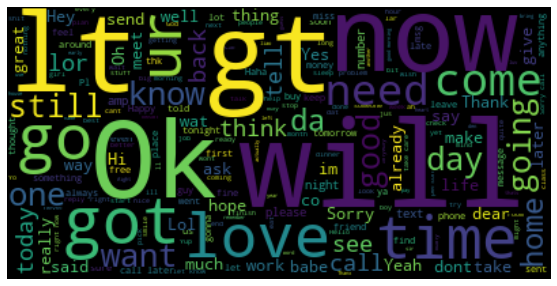

In [18]:
# Create stopword list:
stopwords = set(STOPWORDS)
ham_words = ' '.join(msgs_df[msgs_df['Class'] == 'ham']['SMS'])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="black").generate(ham_words)

# Display the generated image:
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

*We can see some evident differenes (based on our dataset) in the kind of words used in ham and spam messages respectively. This brings human in the loop when looking for explainability after acquiring results from machine learning models.*

In [0]:
#create a length of the text column
msgs_df['length'] = msgs_df['SMS'].apply(len)

In [20]:
#check the dataframe
msgs_df.head()

,SMS,Class,length
0,"Go until jurong point, crazy.. Available only ...",ham,111
1,Ok lar... Joking wif u oni...,ham,29
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam,155
3,U dun say so early hor... U c already then say...,ham,49
4,"Nah I don't think he goes to usf, he lives aro...",ham,61


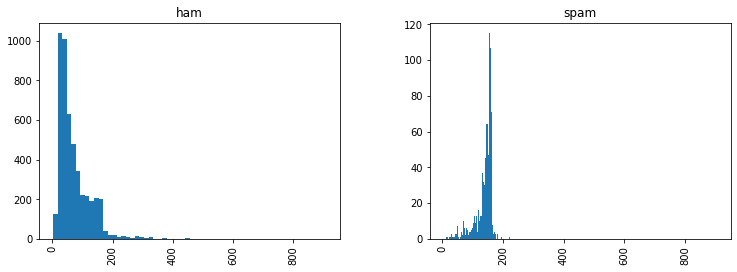

In [21]:
#plot the length of different class texts
msgs_df.hist(column='length',by='Class',bins=60,figsize=(12,4));
plt.xlim(-40,950);

*We can see there are more number of shorter messages in ham than spam.*

In [0]:
#create a function to remove punctuations and stopwords
def remove_punctuation_and_stopwords(sms):
    
    sms_no_punctuation = [ch for ch in sms if ch not in string.punctuation]
    sms_no_punctuation = "".join(sms_no_punctuation).split()
    
    sms_no_punctuation_no_stopwords = \
        [word.lower() for word in sms_no_punctuation if word.lower() not in nltk.corpus.stopwords.words("english")]
        
    return sms_no_punctuation_no_stopwords

In [23]:
#apply function to the SMS column of the dataframe which contains the text messages
msgs_df['SMS'].apply(remove_punctuation_and_stopwords).head()

0    [go, jurong, point, crazy, available, bugis, n...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, 2, wkly, comp, win, fa, cup, fin...
3        [u, dun, say, early, hor, u, c, already, say]
4    [nah, dont, think, goes, usf, lives, around, t...
Name: SMS, dtype: object

*Let's find the top 30 words in ham and spam messages*

In [0]:
#creating a copy of the ham and spam messages
msgs_ham  = msgs_df[msgs_df['Class'] == 'ham'].copy()
msgs_spam = msgs_df[msgs_df['Class'] == 'spam'].copy()

In [0]:
#apply function to remove punctuation and stopwords
msgs_ham.loc[:, 'SMS'] = msgs_ham['SMS'].apply(remove_punctuation_and_stopwords)
words_msgs_ham = msgs_ham['SMS'].tolist()
msgs_spam.loc[:, 'SMS'] = msgs_spam['SMS'].apply(remove_punctuation_and_stopwords)
words_msgs_spam = msgs_spam['SMS'].tolist()

In [0]:
#create a list of words for each class
list_ham_words = []
for sublist in words_msgs_ham:
    for item in sublist:
        list_ham_words.append(item)

list_spam_words = []
for sublist in words_msgs_spam:
    for item in sublist:
        list_spam_words.append(item)

In [0]:
#A frequency distribution visually shows which words are excessively used in each class
fdist_ham  = nltk.FreqDist(list_ham_words)
fdist_spam = nltk.FreqDist(list_spam_words)

In [0]:
#Let's choose the top 30 words for our frequency distribution
df_hamwords_top30 = pd.DataFrame(fdist_ham.most_common(30),  columns=['word', 'count'])
df_spamwords_top30 = pd.DataFrame(fdist_spam.most_common(30), columns=['word', 'count'])

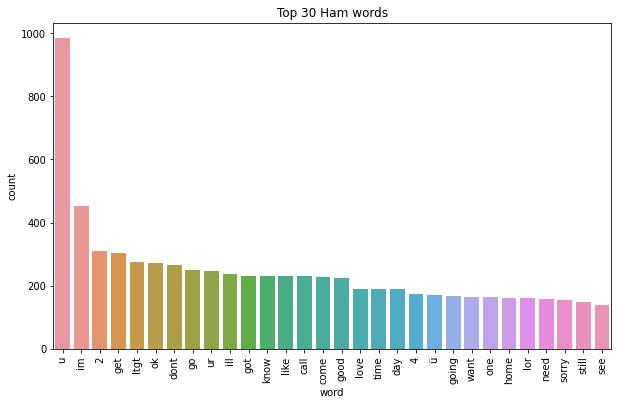

In [29]:
#plot the frequency distribution for top 30 ham words
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='word', y='count', 
            data=df_hamwords_top30, ax=ax)
plt.title("Top 30 Ham words")
plt.xticks(rotation='vertical');

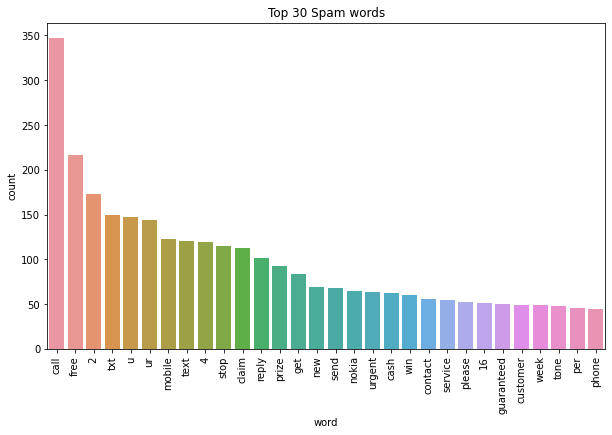

In [30]:
#plot the frequency distribution for top 30 spam words
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='word', y='count', 
            data=df_spamwords_top30, ax=ax)
plt.title("Top 30 Spam words")
plt.xticks(rotation='vertical');

## **Bag of words model**
<a id="bow"></a>

*Now going to apply the "bag of words" using count vectorizer - BOW model. In this case, the text is broken down into a set of words that do not represent any particular order.*

In [0]:
#import countvectorizer used to break down the text into bag of words
from sklearn.feature_extraction.text import CountVectorizer
bow_transformer = CountVectorizer(analyzer = remove_punctuation_and_stopwords).fit(msgs_df['SMS'])

In [32]:
#print number of words in the transformed bag of words
print(len(bow_transformer.vocabulary_))

9530


*Let's see an example of one of the transformed messages of ham and spam each.*

In [33]:
#example of transformed spam message
example_spam = msgs_df['SMS'][8]
bow_example_spam = bow_transformer.transform([example_spam])
print(example_spam)
print(bow_example_spam)

WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.
  (0, 218)	1
  (0, 324)	1
  (0, 1927)	1
  (0, 2206)	2
  (0, 2267)	1
  (0, 2554)	1
  (0, 4238)	1
  (0, 4813)	1
  (0, 5769)	1
  (0, 6609)	1
  (0, 6849)	1
  (0, 7020)	1
  (0, 7289)	1
  (0, 8792)	1
  (0, 8796)	1
  (0, 9128)	1
  (0, 9519)	1


In [34]:
#listing the words from the tested text message
rows, cols = bow_example_spam.nonzero()
for col in cols: 
    print(bow_transformer.get_feature_names()[col])

09061701461
12
call
claim
code
customer
hours
kl341
network
prize
receivea
reward
selected
valid
valued
winner
£900


In [35]:
#check the format
print(np.shape(bow_example_spam))

(1, 9530)


In [36]:
#example of transformed ham message
example_ham = msgs_df['SMS'][6]
bow_example_ham = bow_transformer.transform([example_ham])
print(example_ham)
print(bow_example_ham)

Even my brother is not like to speak with me. They treat me like aids patent.
  (0, 1075)	1
  (0, 1826)	1
  (0, 3199)	1
  (0, 5010)	2
  (0, 6238)	1
  (0, 7721)	1
  (0, 8535)	1


In [37]:
#listing the words from the tested text message
rows, cols = bow_example_ham.nonzero()
for col in cols: 
    print(bow_transformer.get_feature_names()[col])

aids
brother
even
like
patent
speak
treat


In [38]:
#check the format
print(np.shape(bow_example_ham))

(1, 9530)


*Now applying bow transformer model on all the text messages*

In [0]:
#apply the model on all the messages
bow_msgs = bow_transformer.transform(msgs_df['SMS'])

In [40]:
#check the format of the bag of words
bow_msgs.shape

(5574, 9530)

*Check how many non-zeroes are available*

In [41]:
#check the non-zero items
bow_msgs.nnz

50102

In [42]:
#calculate the non-zero percentage
nonzero_percentage = ((bow_msgs.nnz)/((bow_msgs.shape[0]*bow_msgs.shape[1]))*100)
print("nonzero_percentage is ", nonzero_percentage)

nonzero_percentage is  0.09431813347158577


*There are roughly 10% non-zero values in the matrix.*

## **TF-IDF**
<a id="tfidf"></a>

**TF-IDF** - *Term Frequency - Inverse Document Frequency*
- *TfIDF is used to weight the vectors in the documents to identify words that might be more useful to categorize documents/texts. It is also helpful to identify rare words*

In [0]:
#import necessary packages and create the transformer function
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(bow_msgs)

In [44]:
#apply the function on the example ham message
tfidf_example_ham = tfidf_transformer.transform(bow_example_ham)
print(tfidf_example_ham)

  (0, 8535)	0.3449563227900963
  (0, 7721)	0.30975665595319324
  (0, 6238)	0.4536339861734264
  (0, 5010)	0.42623706828325114
  (0, 3199)	0.2800736746309343
  (0, 1826)	0.3367032239772431
  (0, 1075)	0.4536339861734264


In [45]:
#apply the function on the example spam message
tfidf_example_spam = tfidf_transformer.transform(bow_example_spam)
print(tfidf_example_spam)

  (0, 9519)	0.2604704749562644
  (0, 9128)	0.23445410442468242
  (0, 8796)	0.24115538297703254
  (0, 8792)	0.22255196396602828
  (0, 7289)	0.21485018301001318
  (0, 7020)	0.256405203360391
  (0, 6849)	0.29432371435062715
  (0, 6609)	0.17890448987893473
  (0, 5769)	0.21485018301001318
  (0, 4813)	0.29432371435062715
  (0, 4238)	0.22555515434418869
  (0, 2554)	0.19150636249403208
  (0, 2267)	0.21371844502573412
  (0, 2206)	0.34064149340516364
  (0, 1927)	0.1152173145712974
  (0, 324)	0.23877409980487949
  (0, 218)	0.29432371435062715


In [0]:
#apply the function on all the bag of words from across the text messages
msgs_tfidf = tfidf_transformer.transform(bow_msgs)

In [47]:
#check the format
msgs_tfidf.shape

(5574, 9530)

In [0]:
#import package
from sklearn.model_selection import train_test_split

In [0]:
#split the data into train and test data : 30% test data and 70% training data
msgs_tfidf_train, msgs_tfidf_test, class_train, class_test = train_test_split(msgs_tfidf, msgs_df['Class'], test_size = 0.3, random_state = 3)

In [50]:
#check the training set
msgs_tfidf_train

<3901x9530 sparse matrix of type '<class 'numpy.float64'>'
	with 34940 stored elements in Compressed Sparse Row format>

In [0]:
#converting sparse matrix to matrix
msgs_tfidf_train = msgs_tfidf_train.A
msgs_tfidf_test = msgs_tfidf_test.A

In [52]:
#check the format
msgs_tfidf_train.shape

(3901, 9530)

## **Unsupervised Machine Learning  - Clustering**
<a id="cluster"></a>
*Although we have the classes already available, assuming we have a text with no classes avaialble, it would be good to see if they can be classified accurately. I am going to try to apply clustering over the original dataset to see if we can separate them out significantly using this technique.*

In [0]:
#import packages for splitting the data into train and test
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

In [0]:
#split the data into training (70%) and test set (30%)
X = msgs_df['SMS']
Y = msgs_df['Class']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3)

In [0]:
#encoding the text as labels
le = LabelEncoder()
X_train = le.fit_transform(X_train)
Y_train = le.fit_transform(Y_train)

In [0]:
X_train = np.array(X_train)

In [58]:
#applying kmeans clustering
kmeans = KMeans(n_clusters = 2)
kmeans.fit(X_train.reshape(-1,1))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [59]:
#let's test if the clustering has been done correctly
correct = 0
for i in range(len(X_train.reshape(-1,1))):
    predict_me = np.array(X_train[i].astype(float))
    #predict_me = predict_me.reshape(-1, len(predict_me.reshape(-1,1)))
    prediction = kmeans.predict(predict_me.reshape(-1,1))
    if prediction[0] == Y_train[i]:
        correct += 1

print(correct/len(X_train.reshape(-1,1)))

0.49551397077672393


*It shows a 49.5% prediction accuracy which isn't great. Let's plot it to visualise the results.*

In [0]:
#predict the class using training data and compare with exisiting class information
cluster = kmeans.fit_predict(X_train.reshape(-1,1))

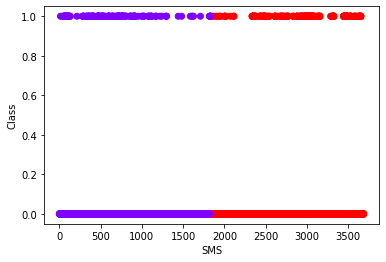

In [61]:
#plot the results
plt.scatter(X_train, Y_train, c=cluster, cmap ='rainbow')
plt.xlabel('SMS')
plt.ylabel('Class')
plt.show()

*As seen in the results, applying clustering to label-encoded text data is not a wise idea as this method considers Euclidean distance rather than relevance or context. In order to classify texts, it is better to apply supervised machine learning models as performed below*



## **Supervised Machine Learning**
<a id="ml"></a>

*Let's apply some powerful classifiers to perform binary classificaiton. I am trying both Multinomial Naive Bayes as well as Gaussian Naive Bayes to see if there are any differnces in performance. I'm also employing Support Vector Machines on the data*

In [0]:
#import packages
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV

In [63]:
#create and apply model
spam_detect_model = MultinomialNB().fit(msgs_tfidf_train, class_train)
pred_test_MNB = spam_detect_model.predict(msgs_tfidf_test)
acc_MNB = accuracy_score(class_test, pred_test_MNB)
print(acc_MNB)

0.9617453676031081


In [64]:
#create and apply model
spam_detect_model_GB = GaussianNB().fit(msgs_tfidf_train, class_train)
pred_test_GB = spam_detect_model.predict(msgs_tfidf_test)
acc_GB = accuracy_score(class_test, pred_test_GB)
print(acc_GB)

0.9617453676031081


In [65]:
#import, create and apply model
from sklearn import svm
model = svm.SVC()
spam_detect_model_SVM = model.fit(msgs_tfidf_train, class_train)
pred_test_SVM = spam_detect_model_SVM.predict(msgs_tfidf_test)
acc_SVM = accuracy_score(class_test, pred_test_SVM)
print(acc_SVM)

0.9713090257023311


### Analysis:
- *The Multinomial as well as Gaussian Naive Bayes are similar in terms of classification accuracy so we will apply only Multinomial Naive Bayes in the following sections.*

- *There is a high possibility of overfitting in this case as this is an imbalanced dataset [1], let's try to perform oversampling to balance the classes.*

- *I have used ADASYN to perform oversampling. It is good practice to separate out the test data prior to applying ADASYN to not impact the authenticity of the test data.* 

In [0]:
#Divide the bag of words messages into training and test class and then oversample training
bow_msgs_train, bow_msgs_test, Class_train_1, Class_test_1 = train_test_split(bow_msgs, msgs_df['Class'], test_size = 0.3, random_state = 5)

In [0]:
#create oversampling function
from collections import Counter
def makeOverSamplesADASYN(A,b):
 #input DataFrame
 #X →Independent Variable in DataFrame\
 #y →dependent Variable in Pandas DataFrame format
 from imblearn.over_sampling import ADASYN 
 sm = ADASYN()
 A, b = sm.fit_sample(A, b)
 print(Counter(b))
 return(A,b)

In [0]:
#assign values to parameters to be applied to the function
A = bow_msgs_train
b = Class_train_1

In [69]:
#check the format
A.shape

(3901, 9530)

In [70]:
#check the format
b.shape

(3901,)

In [71]:
#apply oversampling function
e,f = makeOverSamplesADASYN(A, b)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Counter({'ham': 3391, 'spam': 3328})


*I have oversampled spam data to bring the number close to the count of ham words*

In [72]:
#check results
e

<6719x9530 sparse matrix of type '<class 'numpy.int64'>'
	with 89502 stored elements in Compressed Sparse Row format>

In [73]:
#check results
f

array(['ham', 'ham', 'spam', ..., 'spam', 'spam', 'spam'], dtype=object)

In [0]:
#assign the oversampled data as the new training set for the classification models and apply the tfidf transformer on them
msgs_tfidf_train_new = tfidf_transformer.transform(e)

In [0]:
#assign the tfidf transformer on the test data
msgs_tfidf_test_new = tfidf_transformer.transform(bow_msgs_test)

In [0]:
#assign the new training labels
Class_train_new = f

In [0]:
#assign the new test labels
Class_test_new = Class_test_1

*Let's apply the classification models on the oversampled training data and original test data*

In [78]:
#create and apply Multinomial Naive Bayes
spam_detect_model_new = MultinomialNB().fit(msgs_tfidf_train_new, Class_train_new)
pred_test_MNB_new = spam_detect_model_new.predict(msgs_tfidf_test_new)
acc_MNB_new = accuracy_score(Class_test_new, pred_test_MNB_new)
print(acc_MNB_new)

0.9527794381350867


In [79]:
#create and apply SVM
spam_detect_model_SVM_new = model.fit(msgs_tfidf_train_new, Class_train_new)
pred_test_SVM_new = spam_detect_model_SVM_new.predict(msgs_tfidf_test_new)
acc_SVM_new = accuracy_score(Class_test_new, pred_test_SVM_new)
print(acc_SVM_new)

0.9665271966527197


*The accuracy has reduced in both cases. This could be due to two reasons:*
- *Count vectoriser produces high dimensionality of data. This can mess up how well oversampling works.*
- *The initial accuracy was overfitting and tending towards majority class due to the class imbalance.*

## **Parameter Optimisation - Original Data**
<a id="gds"></a>

*Since SVM performed better, a grid search may help in identifying the optimal parameters for the model.*

In [0]:
#Using pipeline for Gridsearch
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

In [0]:
#divide the original data into train and test
msgs_train_final, msgs_test_final, Class_train_final, Class_test_final = train_test_split(msgs_df['SMS'], msgs_df['Class'], test_size =0.3, random_state = 5)

In [82]:
#create a pipeline of the various functions that need to be applied
pipe_SVC = Pipeline([ ('bow'  , CountVectorizer(analyzer= remove_punctuation_and_stopwords) ),
                   ('tfidf'   , TfidfTransformer()),
                   ('clf_SVC' , SVC(C=1000,kernel ='linear',gamma='auto')),
                    ])

#list out the parameters to be considered during gridsearch
parameters_SVC = dict(tfidf=[None, TfidfTransformer()],
                      clf_SVC__C=[500,1000,1500],
                      clf_SVC__kernel =['linear', 'rbf']
                      )
#Gridsearch and 5-fold cross validation are applied
grid_SVC = GridSearchCV(pipe_SVC, parameters_SVC, 
                        cv=5, n_jobs=-1, verbose=1)

#Fit the model with each of the parameters
grid_SVC.fit(X=msgs_train_final, y=Class_train_final)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  5.5min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('bow',
                                        CountVectorizer(analyzer=<function remove_punctuation_and_stopwords at 0x7fcc5c873378>,
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
      

In [83]:
#retrieve the best parameters of the optimised model
grid_SVC.best_params_

{'clf_SVC__C': 500,
 'clf_SVC__kernel': 'linear',
 'tfidf': TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)}

In [84]:
#predict on test data
pred_test_grid_SVC = grid_SVC.predict(msgs_test_final)
acc_SVC = accuracy_score(Class_test_final, pred_test_grid_SVC)
print(acc_SVC)
print(grid_SVC.score(msgs_test_final, Class_test_final))

0.982068141063957
0.982068141063957


*We can see grid search is improving the accuracy on the original data where the results suggest that, based on the parameters supplied, a box constraint of 500, linear Kernel SVM applied over a tf-idf transformed data would produce a good classification of the text categories*

*Let's calculate the other performance metrics*

In [0]:
#import the necessary packages
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score, precision_recall_curve
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score

In [0]:
#define the confusion matrix function
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    #fig, ax = plt.subplots(figsize=(4,4))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.5,  
                cmap="Blues", square=True, cbar=False)
    #  
    plt.ylabel('true label')
    plt.xlabel('predicted label')

In [0]:
#assign the values
y_true = Class_test_final
y_pred = pred_test_grid_SVC

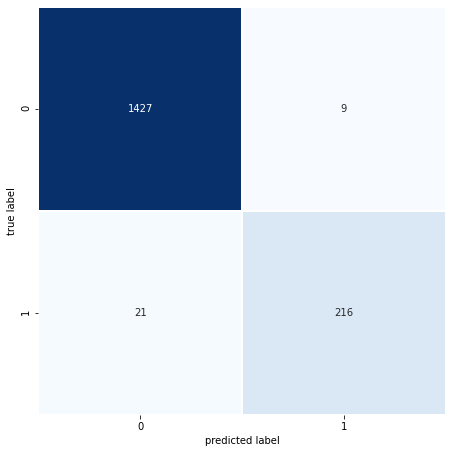

In [88]:
#plot the confusion matrix
plt.figure(figsize= (10, 7.5))
plot_confusion_matrix (y_true, y_pred)

In [89]:
#calculate the other performance metrics
print("\nThe precision score is: ", precision_score(y_true, y_pred, average= None))
print("\nThe recall score is: ", recall_score(y_true, y_pred, average = None))
print("\nThe f1 score is: ", f1_score(y_true, y_pred, average = None))


The precision score is:  [0.98549724 0.96      ]

The recall score is:  [0.99373259 0.91139241]

The f1 score is:  [0.98959778 0.93506494]


*F1 score is a weighted measure of the precision and recall which makes it a better measure of evaluating the classifier. In this case, we can see the F1 score is 98.9% which is a good classification ability given the optimised parameters* 

## **Parameter Optimisation - Oversampled Data**
<a id="gdso"></a>

In [90]:
#create a pipeline of the various functions that need to be applied
pipe_SVC_1 = Pipeline([ 
                   ('clf_SVC' , SVC(C=1000,kernel ='linear',gamma='auto')),
                    ])

#list out the parameters to be considered during gridsearch
parameters_SVC_1 = dict(clf_SVC__C=[500,1000,1500],
                      clf_SVC__kernel =['linear', 'rbf']
                      )

#Gridsearch and 5-fold cross validation are applied
grid_SVC_1 = GridSearchCV(pipe_SVC_1, parameters_SVC_1, 
                        cv=5, n_jobs=-1, verbose=1)

#Fit the model with each of the parameters
grid_SVC_1.fit(X=msgs_tfidf_train_new, y=Class_train_new)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   27.3s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('clf_SVC',
                                        SVC(C=1000, break_ties=False,
                                            cache_size=200, class_weight=None,
                                            coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='auto',
                                            kernel='linear', max_iter=-1,
                                            probability=False,
                                            random_state=None, shrinking=True,
                                            tol=0.001, verbose=False))],
                                verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'clf_SVC__C': [500, 1000, 1500],
                         'clf_SVC__kernel': ['linear', 'rbf']},
             pre_dis

In [91]:
#Retrieve the best parameters of the optimised model
grid_SVC_1.best_params_

{'clf_SVC__C': 1500, 'clf_SVC__kernel': 'rbf'}

In [92]:
#predict over the test data
pred_test_grid_SVC_1 = grid_SVC_1.predict(msgs_tfidf_test_new)
acc_SVC_1 = accuracy_score(Class_test_new, pred_test_grid_SVC_1)
print(acc_SVC_1)
#print(grid_SVC.score(msgs_test_final, Class_test_final))

0.9270771069934249


*We can see grid search has in this case caused the accuracy to drop on the oversampled data where the results suggest that, based on the parameters supplied, a box constraint of 1500 and rbf Kernel SVM applied over a tf-idf transformed data would produce a 92.7% classification of the text categories.*

In [0]:
#define the confusion matrix
def plot_confusion_matrix(y_true_1, y_pred_1):
    mtx = confusion_matrix(y_true_1, y_pred_1)
    #fig, ax = plt.subplots(figsize=(4,4))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.5,  
                cmap="Blues", square=True, cbar=False)
    plt.ylabel('true label')
    plt.xlabel('predicted label')

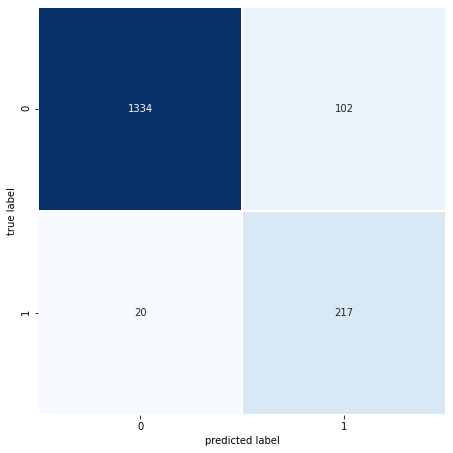

In [95]:
#plot confusion matrix
plt.figure(figsize= (10, 7.5))
plot_confusion_matrix(Class_test_new, pred_test_grid_SVC_1)

In [96]:
#calculate the other performance metrics
print("\nThe precision score is: ", precision_score(Class_test_new, pred_test_grid_SVC_1, average = None))
print("\nThe recall score is: ", recall_score(Class_test_new, pred_test_grid_SVC_1, average = None))
print("\nThe f1 score is: ", f1_score(Class_test_new, pred_test_grid_SVC_1, average = None))


The precision score is:  [0.98522895 0.68025078]

The recall score is:  [0.92896936 0.91561181]

The f1 score is:  [0.9562724  0.78057554]


*F1 score is a weighted measure of the precision and recall which makes it a better measure of evaluating the classifier. In this case, we can see the F1 score is 95.6% which is a good classification ability given the optimised parameters.*

## **Critical Analysis**
<a id="ca"></a>

- *As seen in the results, applying clustering to label-encoded text data is not a wise idea as this method considers Euclidean distance rather than relevance or context. In order to classify texts, it is better to apply supervised machine learning models.*
- *Based on the experiments performed, we can see the grid search on the original data where the tf-idf was applied and fed into an SVM model produced the best results. This is despite the class imbalance in the data.*
- *Although there is evidence of being able to improve performance by oversampling by different ratios in [1], perhaps in this dataset, the oversampling may not be adding value. This could be because the oversampling was applied to the bag of words. It would be good to experiment different ratios of oversampling on a different format of the dataset to see if it improves the classification performance metrics.*



## **References**
<a id="ref"></a>
[1] Habib, M., Faris, H., Hassonah, M.A., Alqatawna, J., Sheta, A.F. & Al-Zoubi, A.M. 2018, "Automatic Email Spam Detection using Genetic Programming with SMOTE", IEEE, , pp. 185.